In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
import json 
from pandas import json_normalize
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic, ccf
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit


import pandas as pd
import numpy as np
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from missingpy import MissForest
from missingpy import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from functools import reduce
from sklearn.model_selection import KFold
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', None)

In [182]:
def set_target_in_ph(data, prediction_horizon):
    ph_col_name = 'target_in_oh_{}'.format(prediction_horizon)
    data[ph_col_name] = data['sales_quantity'].shift(-1 * prediction_horizon)
    return data

def check_stationarity(timeseries_p, col_name):
    print('Results of Dickey-Fuller Test for {}:'.format(col_name))
    dftest = adfuller(timeseries_p, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def detrend(series, window_size=10):
    moving_avg = series.rolling(window=window_size).mean()
    series = series - moving_avg
    return series


def difference(series):
    series = series - series.shift()
    return series


def set_vector_date(data, vector_length):
    vector_columns = numeric_cols
    for col in vector_columns:
        col_name = col
        for i in range(vector_length):
            new_col = col_name + '_t-{}'.format(i + 1)
            data[new_col] = data[col].shift(i + 1)
    return data




In [140]:
df = pd.read_csv('data.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1878 entries, 0 to 1877
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1878 non-null   int64  
 1   day                     1878 non-null   object 
 2   item_number             1878 non-null   int64  
 3   item_name               1878 non-null   object 
 4   purchase_price          1878 non-null   float64
 5   suggested_retail_price  1878 non-null   float64
 6   orders_quantity         1878 non-null   float64
 7   sales_quantity          1878 non-null   float64
 8   revenue                 926 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 132.2+ KB
None


,Unnamed: 0,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
0,0,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
1,1,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
2,2,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
3,3,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
4,4,2022-02-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.64,0.99,0.0,13.0,12.84


In [141]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [142]:
df = df.sort_values('day')

In [143]:
df.drop(['revenue'], axis=1, inplace=True)

In [144]:
df.item_number.value_counts()

80101923    626
80028349    626
80317483    626
Name: item_number, dtype: int64

In [145]:
df[['item_number', 'item_name']].value_counts()

item_number  item_name                     
80028349     UH ZWIEBELN DE-HE I 1KG GS        626
80101923     SL MANDARINEN BEH.ES I 750G GS    626
80317483     ROMA TOMATEN ES I 500G SF         626
dtype: int64

In [146]:
df['day'] = pd.to_datetime(df['day'])

In [147]:
df.describe()

,item_number,purchase_price,suggested_retail_price,orders_quantity,sales_quantity
count,1.878000e+03,1878.000000,1878.000000,1878.000000,1878.000000
mean,8.014925e+07,1.216796,1.941402,8.602769,8.235357
std,1.227237e+05,0.568129,0.936656,14.981958,11.510945
min,8.002835e+07,0.520000,0.660000,0.000000,0.000000
25%,8.002835e+07,0.674928,1.055314,0.000000,0.000000
50%,8.010192e+07,0.978451,1.546338,0.000000,0.000000
75%,8.031748e+07,1.991321,3.216415,18.000000,15.000000
max,8.031748e+07,2.150000,3.490000,144.000000,85.000000


In [148]:
df[['orders_quantity', 'sales_quantity']].corr()

,orders_quantity,sales_quantity
orders_quantity,1.000000,0.665446
sales_quantity,0.665446,1.000000


<AxesSubplot:xlabel='day', ylabel='orders_quantity'>

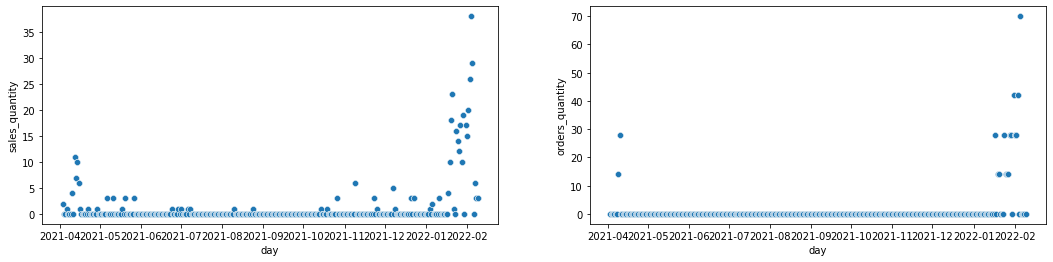

In [149]:
data = df[df['item_number'] == 80101923]
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18,4))

sns.scatterplot(data=data, x="day", y="sales_quantity", ax = axs[0])
sns.scatterplot(data=data, x="day", y="orders_quantity", ax = axs[1])



<AxesSubplot:xlabel='day', ylabel='orders_quantity'>

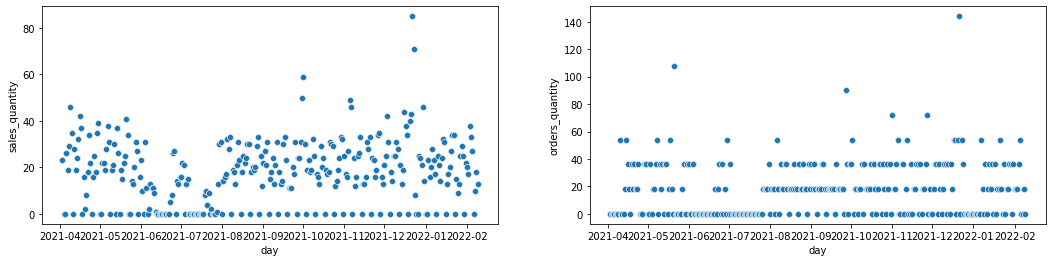

In [150]:
data = df[df['item_number'] == 80028349]
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18,4))

sns.scatterplot(data=data, x="day", y="sales_quantity", ax = axs[0])
sns.scatterplot(data=data, x="day", y="orders_quantity", ax = axs[1])



<AxesSubplot:xlabel='day', ylabel='orders_quantity'>

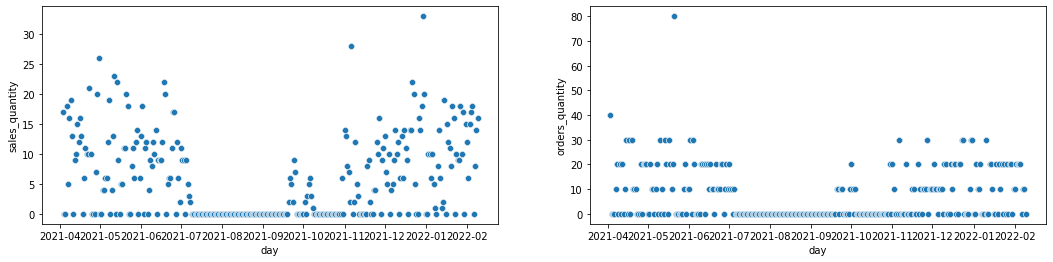

In [151]:
data = df[df['item_number'] == 80317483]
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18,4))

sns.scatterplot(data=data, x="day", y="sales_quantity", ax = axs[0])
sns.scatterplot(data=data, x="day", y="orders_quantity", ax = axs[1])



<AxesSubplot:xlabel='day', ylabel='orders_quantity'>

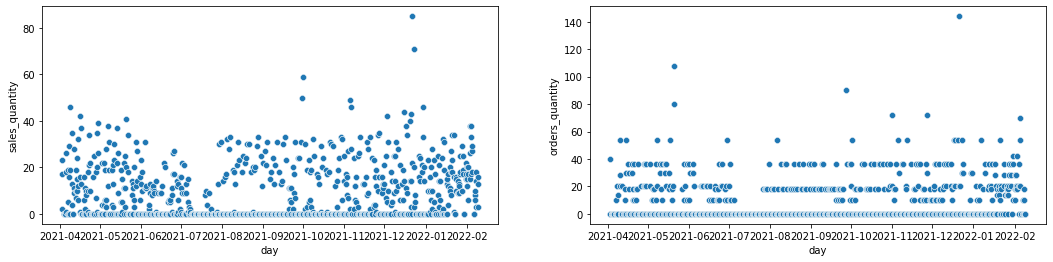

In [152]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18,4))

sns.scatterplot(data=df, x="day", y="sales_quantity", ax = axs[0])
sns.scatterplot(data=df, x="day", y="orders_quantity", ax = axs[1])



In [153]:
df = df.drop_duplicates()

In [154]:
df['unit_profit'] = df['suggested_retail_price'] - df['purchase_price']

In [155]:
df = df.groupby('day').agg({'purchase_price':'mean', 'suggested_retail_price': 'mean', 'unit_profit': 'mean', 'orders_quantity': 'sum', 'sales_quantity': 'sum'}).reset_index()

# Dependencies of Independent Varaiables to Target Variable

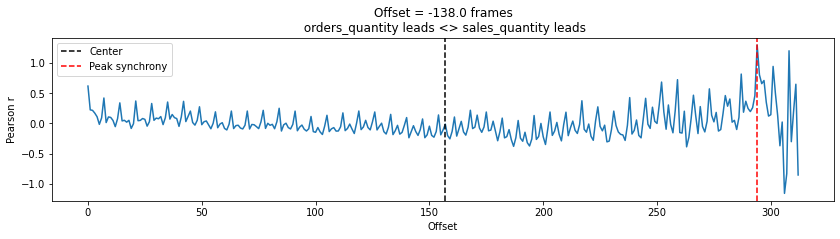

In [156]:
input_cols = ['orders_quantity','sales_quantity']
for i in range(len(input_cols)):
    for j in range(i+1, len(input_cols)):
        ccres = ccf(df[input_cols[i]], df[input_cols[j]], adjusted=True)
        if ccres.max()>0.3:
            rs=ccres
            offset = np.floor(len(rs)/2)-np.argmax(rs)
            f,ax=plt.subplots(figsize=(14,3))
            ax.plot(rs)
            ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
            ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
            ax.set(title='Offset = {} frames\n {} leads <> {} leads'.format(offset, input_cols[i], input_cols[j]), xlabel='Offset',ylabel='Pearson r')

            plt.legend()

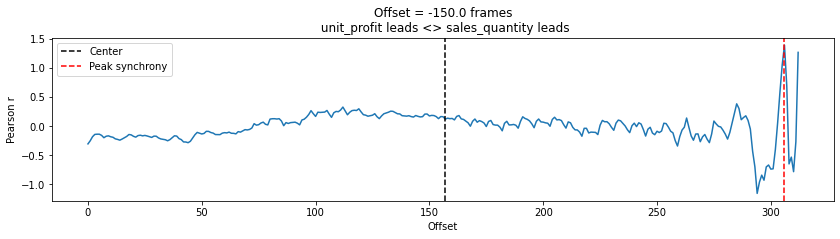

In [157]:
input_cols = ['unit_profit','sales_quantity']
for i in range(len(input_cols)):
    for j in range(i+1, len(input_cols)):
        ccres = ccf(df[input_cols[i]], df[input_cols[j]], adjusted=True)
        if ccres.max()>0.3:
            rs=ccres
            offset = np.floor(len(rs)/2)-np.argmax(rs)
            f,ax=plt.subplots(figsize=(14,3))
            ax.plot(rs)
            ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
            ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
            ax.set(title='Offset = {} frames\n {} leads <> {} leads'.format(offset, input_cols[i], input_cols[j]), xlabel='Offset',ylabel='Pearson r')

            plt.legend()

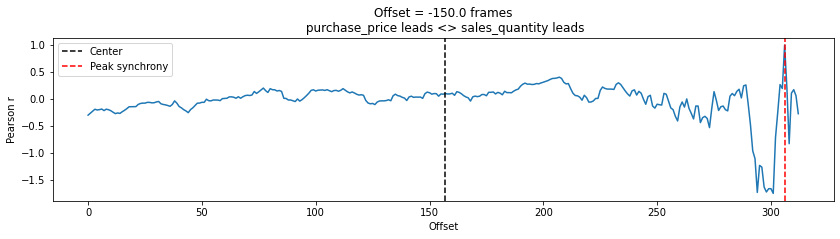

In [158]:
input_cols = ['purchase_price','sales_quantity']
for i in range(len(input_cols)):
    for j in range(i+1, len(input_cols)):
        ccres = ccf(df[input_cols[i]], df[input_cols[j]], adjusted=True)
        if ccres.max()>0.3:
            rs=ccres
            offset = np.floor(len(rs)/2)-np.argmax(rs)
            f,ax=plt.subplots(figsize=(14,3))
            ax.plot(rs)
            ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
            ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
            ax.set(title='Offset = {} frames\n {} leads <> {} leads'.format(offset, input_cols[i], input_cols[j]), xlabel='Offset',ylabel='Pearson r')

            plt.legend()

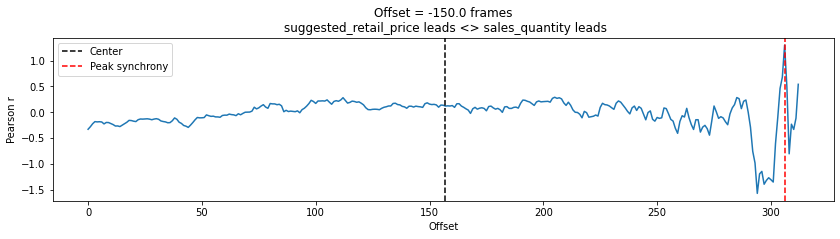

In [159]:
input_cols = ['suggested_retail_price','sales_quantity']
for i in range(len(input_cols)):
    for j in range(i+1, len(input_cols)):
        ccres = ccf(df[input_cols[i]], df[input_cols[j]], adjusted=True)
        if ccres.max()>0.3:
            rs=ccres
            offset = np.floor(len(rs)/2)-np.argmax(rs)
            f,ax=plt.subplots(figsize=(14,3))
            ax.plot(rs)
            ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
            ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
            ax.set(title='Offset = {} frames\n {} leads <> {} leads'.format(offset, input_cols[i], input_cols[j]), xlabel='Offset',ylabel='Pearson r')

            plt.legend()

# Building Time Series Model

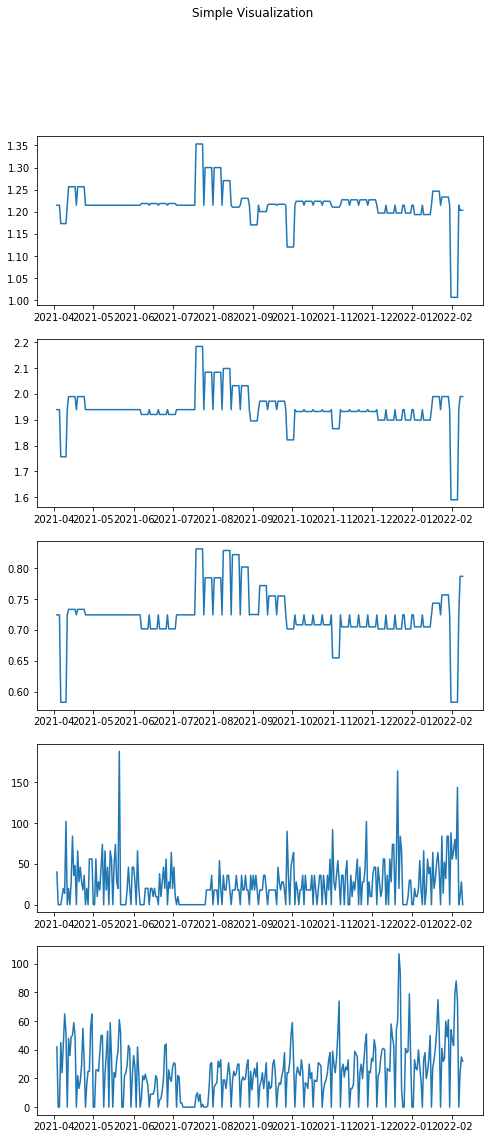

In [161]:
fig, axs = plt.subplots(5, figsize=(8,18))
fig.suptitle('Simple Visualization')
numeric_cols=['purchase_price','suggested_retail_price','unit_profit','orders_quantity','sales_quantity']
for i in range(len(numeric_cols)):
    axs[i].plot(df['day'], df.sort_values('day', ascending=True)[numeric_cols[i]])
#     if numeric_cols[i] in ['target','input_1','input_4','input_5','input_6']:
#         axs[i].set_yscale('log')


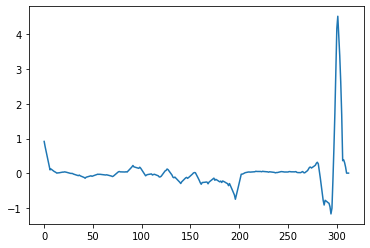

In [162]:
cc_p_s = ccf(df['purchase_price'], df['suggested_retail_price'], adjusted=True)
cc_s_p = ccf(df['suggested_retail_price'], df['purchase_price'], adjusted=True)
plt.plot(cc_p_s)

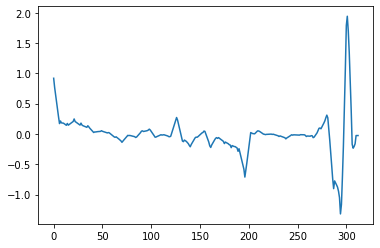

In [163]:
plt.plot(cc_s_p)

### Distributions

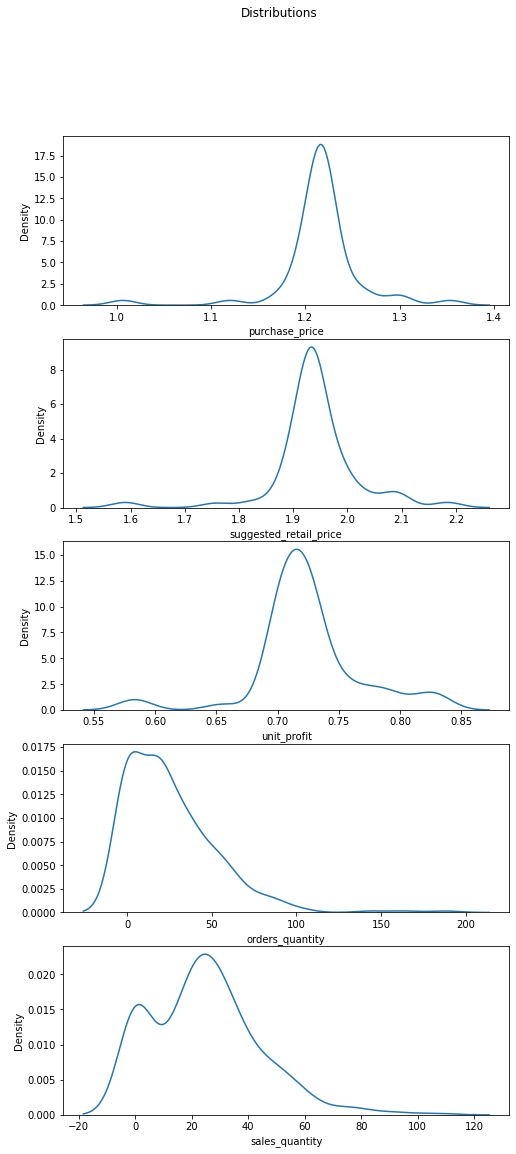

In [164]:
fig, axs = plt.subplots(5, figsize=(8,18))
fig.suptitle('Distributions')
for i in range(len(numeric_cols)):
    axs[i] = sns.kdeplot(data=df, x=numeric_cols[i], ax=axs[i])

### Temporal Characteristics

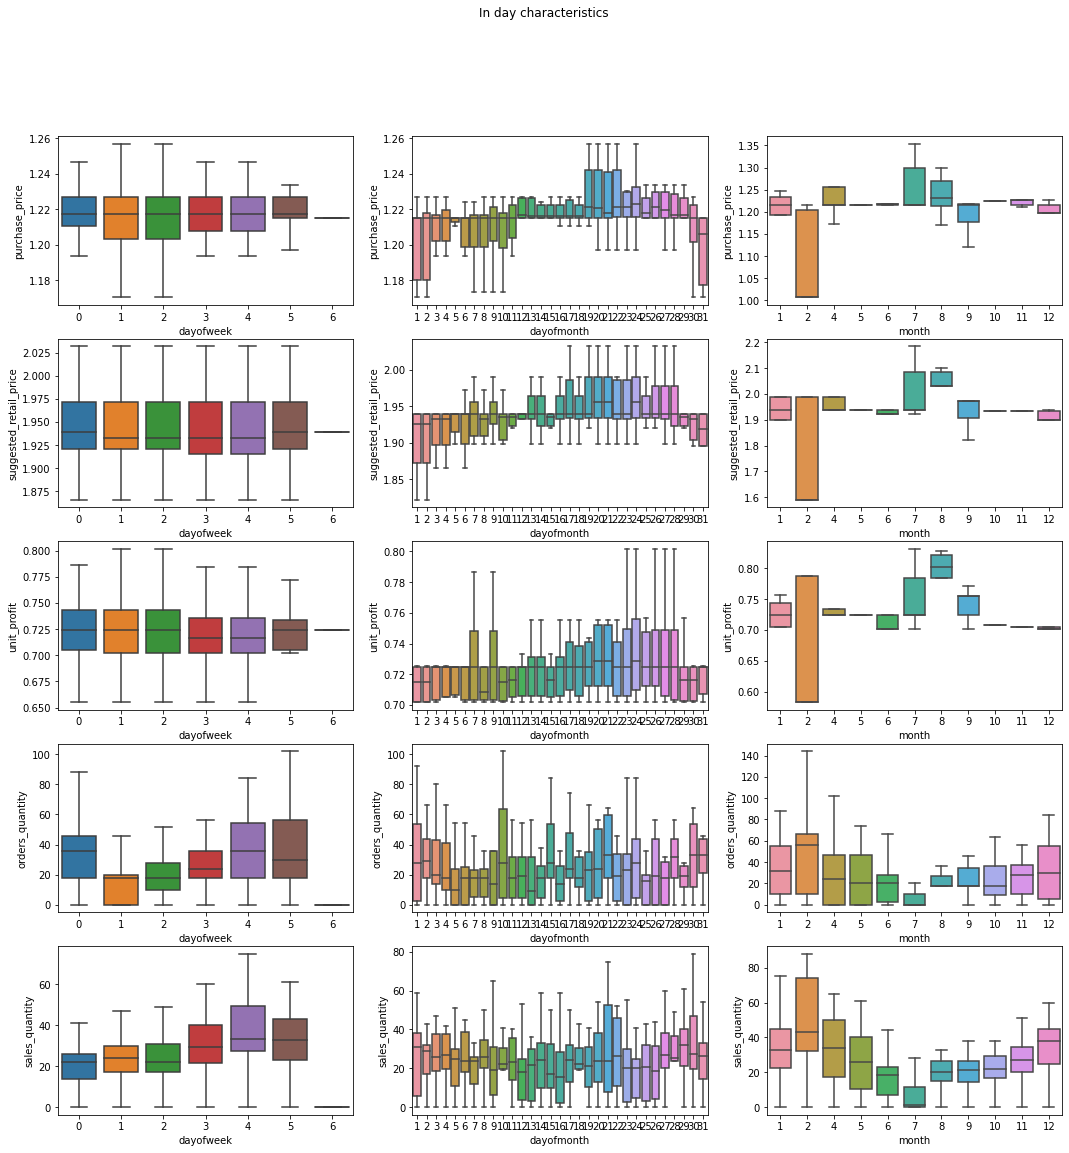

In [165]:
df['dayofweek'] = df['day'].dt.dayofweek
df['dayofmonth'] = df['day'].dt.day
df['month'] = df['day'].dt.month

fig, axs = plt.subplots(5,3, figsize=(18,18))
fig.suptitle('In day characteristics')
for i in range(len(numeric_cols)):
    df_week_day = df.groupby('dayofweek')[numeric_cols[i]].mean().reset_index()
    df_month_date = df.groupby('dayofmonth')[numeric_cols[i]].mean().reset_index()
    data_month = df.groupby('month')[numeric_cols[i]].mean().reset_index()

    sns.boxplot(data=df, x='dayofweek', y=numeric_cols[i], ax=axs[i,0], showfliers = False)
    sns.boxplot(data=df, x='dayofmonth', y=numeric_cols[i], ax=axs[i,1], showfliers = False)
    sns.boxplot(data=df, x='month', y=numeric_cols[i], ax=axs[i,2], showfliers = False)

### Seasonal Decomposition of Target

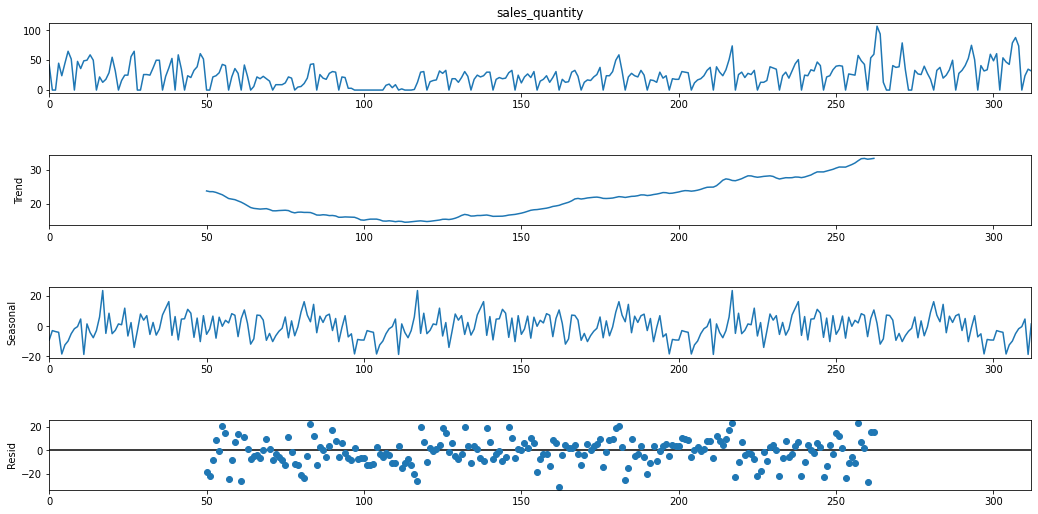

In [166]:
res = sm.tsa.seasonal_decompose(df['sales_quantity'],freq=100,model="additive")

fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(16)

### Stationarity

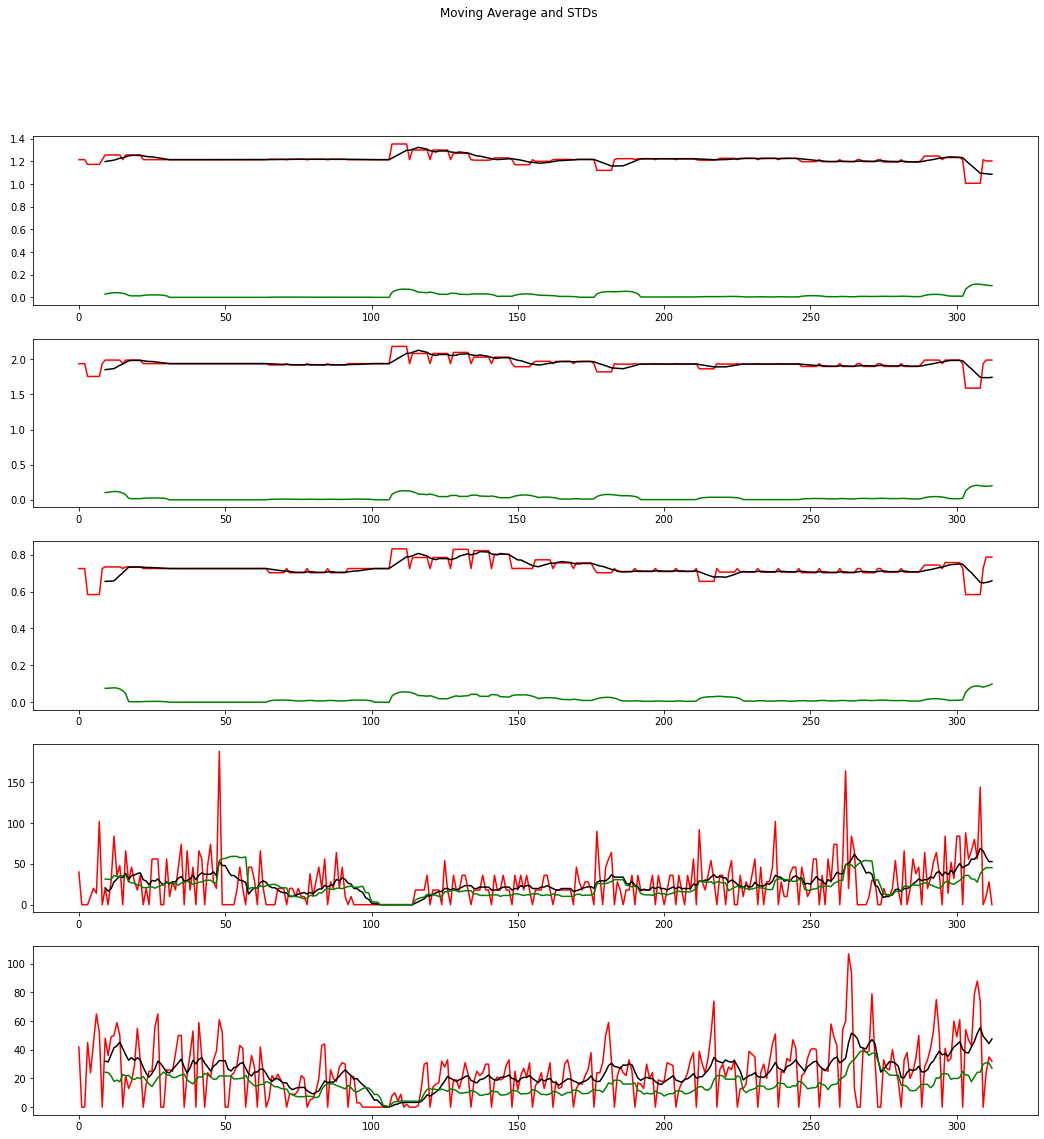

In [167]:
def check_mean_std(data):
    fig, axs = plt.subplots(5, figsize=(18, 18))
    fig.suptitle('Moving Average and STDs')
    for i in range(len(numeric_cols)):
        timeseries = df[numeric_cols[i]]
        rolmean = timeseries.rolling(window=10).mean()
        rolstd = timeseries.rolling(window=10).std()

        orig = axs[i].plot(timeseries, color='red', label='Original')
        mean = axs[i].plot(rolmean, color='black', label='Rolling Mean')
        std = axs[i].plot(rolstd, color='green', label='Rolling Std')

check_mean_std(df)

In [168]:

for col in numeric_cols:
    check_stationarity(df[col], col)
    print()

Results of Dickey-Fuller Test for purchase_price:
Test Statistic                  -2.765214
p-value                          0.063417
#Lags Used                      13.000000
Number of Observations Used    299.000000
Critical Value (1%)             -3.452411
Critical Value (5%)             -2.871255
Critical Value (10%)            -2.571947
dtype: float64

Results of Dickey-Fuller Test for suggested_retail_price:
Test Statistic                  -2.421168
p-value                          0.135851
#Lags Used                      15.000000
Number of Observations Used    297.000000
Critical Value (1%)             -3.452561
Critical Value (5%)             -2.871321
Critical Value (10%)            -2.571982
dtype: float64

Results of Dickey-Fuller Test for unit_profit:
Test Statistic                  -2.383696
p-value                          0.146391
#Lags Used                      15.000000
Number of Observations Used    297.000000
Critical Value (1%)             -3.452561
Critical Value 

- All of our features except orders_quantity has non-stationaity

In [169]:
set(numeric_cols) -  set(['orders_quantity'])

{'purchase_price', 'sales_quantity', 'suggested_retail_price', 'unit_profit'}

Results of Dickey-Fuller Test for purchase_price:
Test Statistic                  -5.515812
p-value                          0.000002
#Lags Used                      13.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64
Results of Dickey-Fuller Test for sales_quantity:
Test Statistic                  -5.137584
p-value                          0.000012
#Lags Used                      14.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64
Results of Dickey-Fuller Test for unit_profit:
Test Statistic                  -5.491340
p-value                          0.000002
#Lags Used                      15.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)      

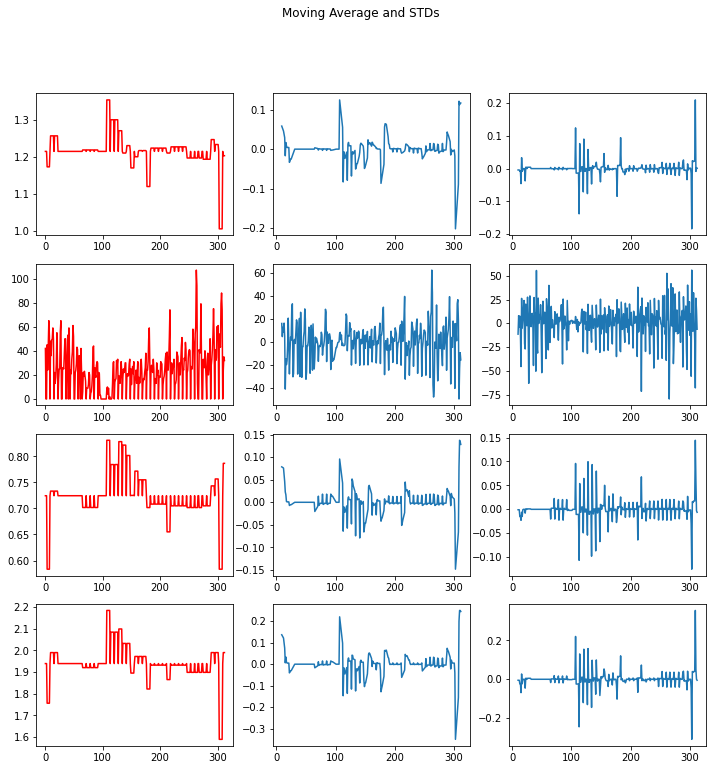

In [170]:
non_stationary_cols = list(set(numeric_cols) -  set(['orders_quantity']))

fig, axs = plt.subplots(4,3, figsize=(12,12))
fig.suptitle('Moving Average and STDs')
for i in range(len(non_stationary_cols)):
    col=non_stationary_cols[i]
    
    #detrending
    ts = df[col]
    window_size = 10
    moving_avg = ts.rolling(window=window_size).mean()

    #
    ts_moving_avg_diff = ts - moving_avg
    ts_moving_avg_diff.dropna(inplace=True)
    
    ts_diff = ts_moving_avg_diff - ts_moving_avg_diff.shift()
    
    axs[i,0].plot(ts, color='red',label='Original')
    axs[i,1].plot(ts_moving_avg_diff, label='Detrended')
    axs[i,2].plot(ts_diff, label='Differenced')
    
    check_stationarity(ts_moving_avg_diff, col)


## Preparing the data

In [176]:
df_pred=df[['day','purchase_price','suggested_retail_price','unit_profit','orders_quantity','sales_quantity']]

df_pred['purchase_price'] = detrend(df_pred['purchase_price'])
df_pred['purchase_price'] = difference(df_pred['purchase_price'])

df_pred['suggested_retail_price'] = detrend(df_pred['suggested_retail_price'])
df_pred['suggested_retail_price'] = difference(df_pred['suggested_retail_price'])

df_pred['unit_profit'] = detrend(df_pred['unit_profit'])
df_pred['unit_profit'] = difference(df_pred['unit_profit'])


In [178]:
df_pred = df_pred.dropna(axis=0)

In [183]:
prediction_horizon = 1
vector_length = 6

df_pred = set_vector_date(df_pred, vector_length)
df_pred = set_target_in_ph(df_pred, prediction_horizon)

df_pred.dropna(inplace=True)
df_pred.head()

,day,purchase_price,suggested_retail_price,unit_profit,orders_quantity,sales_quantity,purchase_price_t-1,purchase_price_t-2,purchase_price_t-3,purchase_price_t-4,purchase_price_t-5,purchase_price_t-6,suggested_retail_price_t-1,suggested_retail_price_t-2,suggested_retail_price_t-3,suggested_retail_price_t-4,suggested_retail_price_t-5,suggested_retail_price_t-6,unit_profit_t-1,unit_profit_t-2,unit_profit_t-3,unit_profit_t-4,unit_profit_t-5,unit_profit_t-6,orders_quantity_t-1,orders_quantity_t-2,orders_quantity_t-3,orders_quantity_t-4,orders_quantity_t-5,orders_quantity_t-6,sales_quantity_t-1,sales_quantity_t-2,sales_quantity_t-3,sales_quantity_t-4,sales_quantity_t-5,sales_quantity_t-6,target_in_oh_1
16,2021-04-19,0.033434,0.027311,-0.006123,66.0,22.0,-0.045924,-0.008333,-0.008333,-0.004177,-0.004177,-0.004177,-0.068913,-0.023333,-0.023333,-0.005064,-0.005064,-0.005064,-0.022990,-0.015000,-0.015000,-0.000888,-0.000888,-0.000888,0.0,48.0,36.0,84.0,28.0,0.0,0.0,50.0,59.0,50.0,49.0,36.0,13.0
17,2021-04-20,-0.008333,-0.023333,-0.015000,28.0,13.0,0.033434,-0.045924,-0.008333,-0.008333,-0.004177,-0.004177,0.027311,-0.068913,-0.023333,-0.023333,-0.005064,-0.005064,-0.006123,-0.022990,-0.015000,-0.015000,-0.000888,-0.000888,66.0,0.0,48.0,36.0,84.0,28.0,22.0,0.0,50.0,59.0,50.0,49.0,18.0
18,2021-04-21,-0.004177,-0.005064,-0.000888,46.0,18.0,-0.008333,0.033434,-0.045924,-0.008333,-0.008333,-0.004177,-0.023333,0.027311,-0.068913,-0.023333,-0.023333,-0.005064,-0.015000,-0.006123,-0.022990,-0.015000,-0.015000,-0.000888,28.0,66.0,0.0,48.0,36.0,84.0,13.0,22.0,0.0,50.0,59.0,50.0,29.0
19,2021-04-22,0.000000,0.000000,0.000000,28.0,29.0,-0.004177,-0.008333,0.033434,-0.045924,-0.008333,-0.008333,-0.005064,-0.023333,0.027311,-0.068913,-0.023333,-0.023333,-0.000888,-0.015000,-0.006123,-0.022990,-0.015000,-0.015000,46.0,28.0,66.0,0.0,48.0,36.0,18.0,13.0,22.0,0.0,50.0,59.0,55.0
20,2021-04-23,0.000000,0.000000,0.000000,18.0,55.0,0.000000,-0.004177,-0.008333,0.033434,-0.045924,-0.008333,0.000000,-0.005064,-0.023333,0.027311,-0.068913,-0.023333,0.000000,-0.000888,-0.015000,-0.006123,-0.022990,-0.015000,28.0,46.0,28.0,66.0,0.0,48.0,29.0,18.0,13.0,22.0,0.0,50.0,32.0


# GBM

In [197]:
rmse_list_test = []
rmse_list_train = []
r2_list_test = []
r2_list_train = []

x = df_pred.drop(['day', 'target_in_oh_1'], axis = 1)
y = df_pred['target_in_oh_1']



seed = 42
x_train_, x_test_, y_train_, y_test_ = train_test_split(x, y, test_size=0.20, random_state=seed, shuffle=True)



kf = KFold(n_splits=5, random_state=42, shuffle=True)

tscv = TimeSeriesSplit()
i = 0


for train_index, test_index in tscv.split(x_train_):
    x_train, x_test = x_train_[train_index], x_train_[test_index]
    y_train, y_test = y_train_.iloc[train_index], y_train_.iloc[test_index]
    
   
    model = GradientBoostingRegressor(random_state=seed, n_estimators=10, max_depth=1)    
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)


    rmse_train_cr = mean_squared_error(y_train, y_pred_train)**.5
    rmse_test_cr = mean_squared_error(y_test, y_pred_test)**.5
    coefficient_of_dermination_cr = r2_score(y_test, y_pred_test)


    print('Fold {}'.format(i))
    print('Train error:', rmse_train_cr)
    print('Test error:', rmse_test_cr)
    print('R_squared:', coefficient_of_dermination_cr)

    
    rmse_list_test.append(rmse_test_cr)
    rmse_list_train.append(rmse_train_cr)
    r2_list_test.append(coefficient_of_dermination_cr)
    
    i = i+1

imputed
Fold 0
Train error: 14.86866120858759
Test error: 16.438937172441324
R_squared: 0.27069545585852284
Fold 1
Train error: 15.179611920978894
Test error: 17.385146747508443
R_squared: 0.2192418950625905
Fold 2
Train error: 15.788417741246903
Test error: 16.33925797500312
R_squared: 0.28511636927339834


In [201]:
model = GradientBoostingRegressor(random_state=seed, n_estimators=10, max_depth=1)    
model.fit(x_train_, y_train_)

y_pred_train = model.predict(x_train_)
y_pred_test = model.predict(x_test_)


rmse_train_cr = mean_squared_error(y_train_, y_pred_train)**.5
rmse_test_cr = mean_squared_error(y_test_, y_pred_test)**.5
coefficient_of_dermination_cr = r2_score(y_test_, y_pred_test)

print('Train error:', rmse_train_cr)
print('Test error:', rmse_test_cr)
print('R_squared:', coefficient_of_dermination_cr)

Train error: 15.875404150793608
Test error: 13.925711526444132
R_squared: 0.32597426685629116
